<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/3_Time_Series_Momentum_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Momentum

## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpJtU6uS/remotes46029de7af3/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coinmetrics daily data

In [3]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices %>% 
  head()


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


# Creating research universe

In [4]:
# snippet: rw crypto flag universe consituents v0.1
create_universe <- function(prices, n=10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & date >= '2015-04-01') %>%
    na.omit() %>%
    ungroup()
}

In [5]:
universe <- create_universe(prices, n = 10, min_constituents = 10)
universe %>%
  head()

ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-07-18,0.08584000,295959.2,1,FALSE
BTC,2010-07-19,0.08080000,279285.2,1,FALSE
BTC,2010-07-20,0.07473573,259000.4,1,FALSE
BTC,2010-07-21,0.07919286,275266.5,1,FALSE
BTC,2010-07-22,0.05846976,203749.6,1,FALSE
BTC,2010-07-23,0.06059287,211735.7,1,FALSE


## Time Series Momentum 

`geom_smooth()` using formula = 'y ~ x'


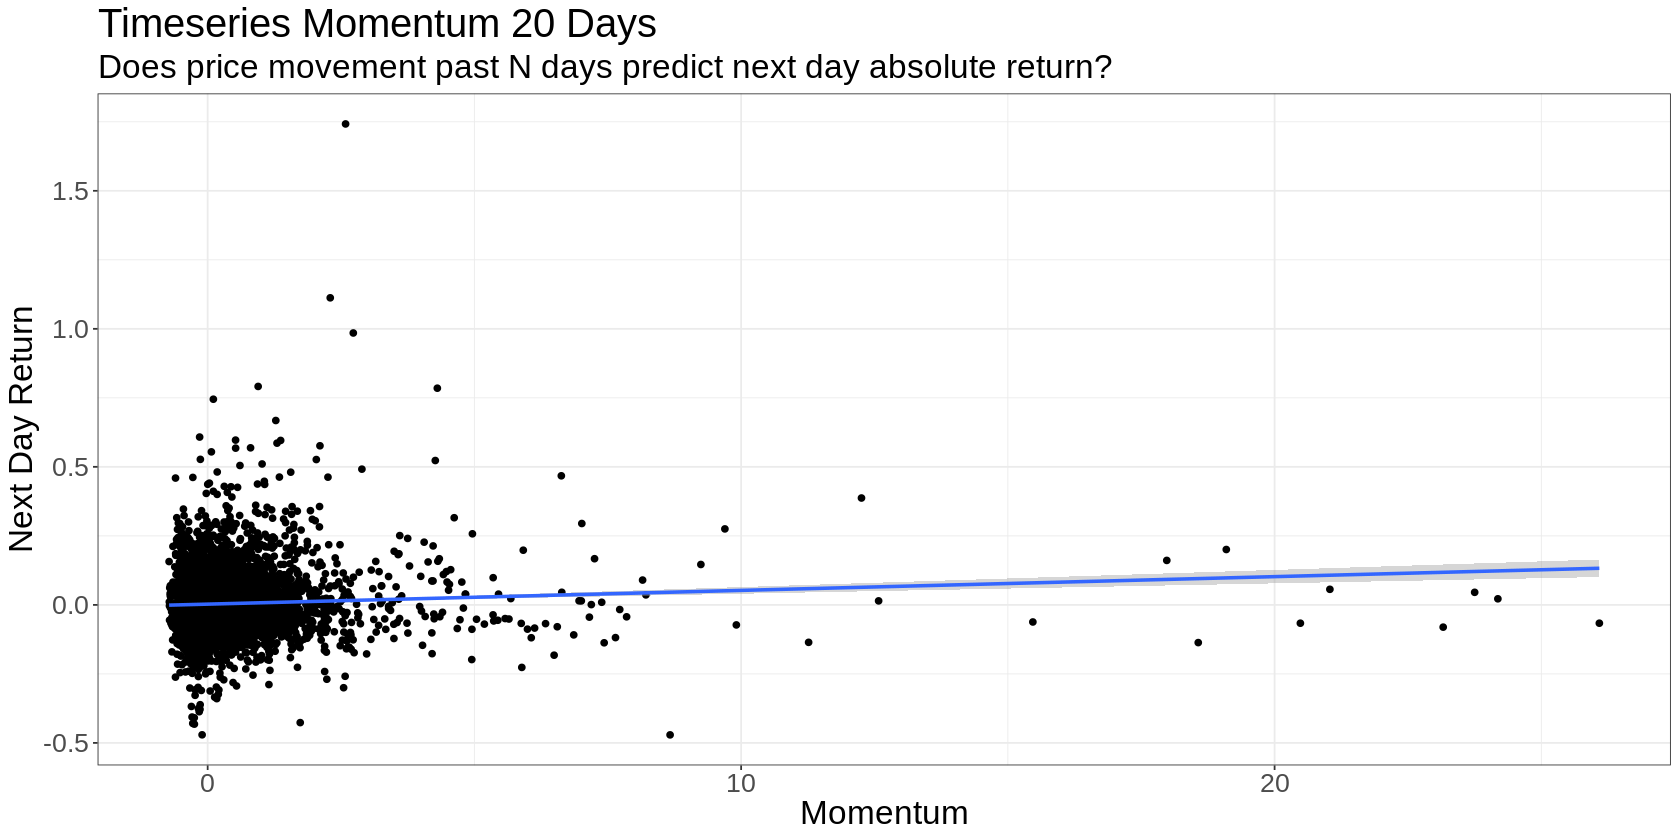

In [6]:
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(momo20 = price_usd / lag(price_usd, n = 20) - 1,
         lagmomo20 = lag(momo20)) %>% 
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup()

returns %>%
  filter(is_index == TRUE ) %>%
  na.omit() %>%
  ggplot(aes(x=momo20,y=fwd_simple_return)) +
  geom_point() +
  geom_smooth(method = 'lm') + 
  labs(
    title = "Timeseries Momentum 20 Days",
    subtitle = "Does price movement past N days predict next day absolute return?",
    x = 'Momentum',
    y = 'Next Day Return'
  )

Let's look at some more lookbacks... 

`geom_smooth()` using formula = 'y ~ x'


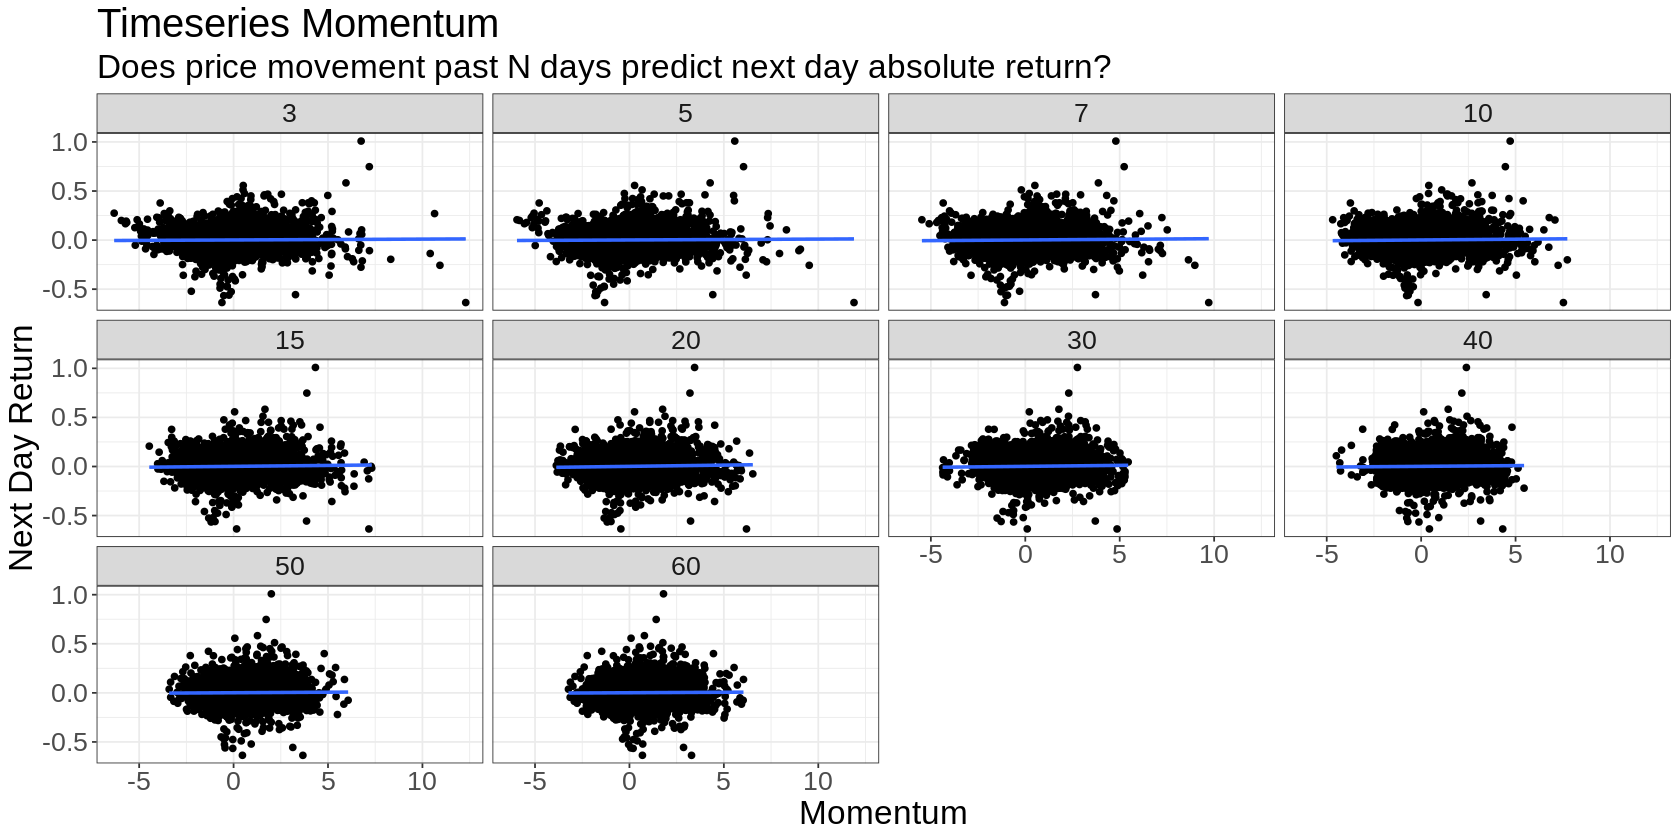

In [7]:
lookback_returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = log(price_usd / lag(price_usd, n = 3)),
    "5" = log(price_usd / lag(price_usd, n = 5)),
    "7" = log(price_usd / lag(price_usd, n = 7)),
    "10" = log(price_usd / lag(price_usd, n = 10)),
    "15" = log(price_usd / lag(price_usd, n = 15)),
    "20" = log(price_usd / lag(price_usd, n = 20)),
    "30" = log(price_usd / lag(price_usd, n = 30)),
    "40" = log(price_usd / lag(price_usd, n = 40)),
    "50" = log(price_usd / lag(price_usd, n = 50)),
    "60" = log(price_usd / lag(price_usd, n = 60)),
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback)) %>%
  # Zscore all the returns to scale them
  group_by(lookback, ticker) %>%
  mutate(momo_zscore = (momo - mean(momo)) / sd(momo)) %>%
  mutate(momo_decile = ntile(momo, 10))


lookback_returns %>%
  filter(is_index == TRUE ) %>%
  na.omit() %>%
  ggplot(aes(x=momo_zscore,y=fwd_log_return)) +
  geom_point() +
  geom_smooth(method = 'lm') + 
  labs(
    title = "Timeseries Momentum",
    subtitle = "Does price movement past N days predict next day absolute return?",
    x = 'Momentum',
    y = 'Next Day Return'
  ) + facet_wrap(~lookback)


Same universe.

Calculate 20 day momentum factor.

For each asset, rank all the momentum observations into deciles *over the full population*.

Group by decile, plot mean next day log return.

Each sub-plot is a different year.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


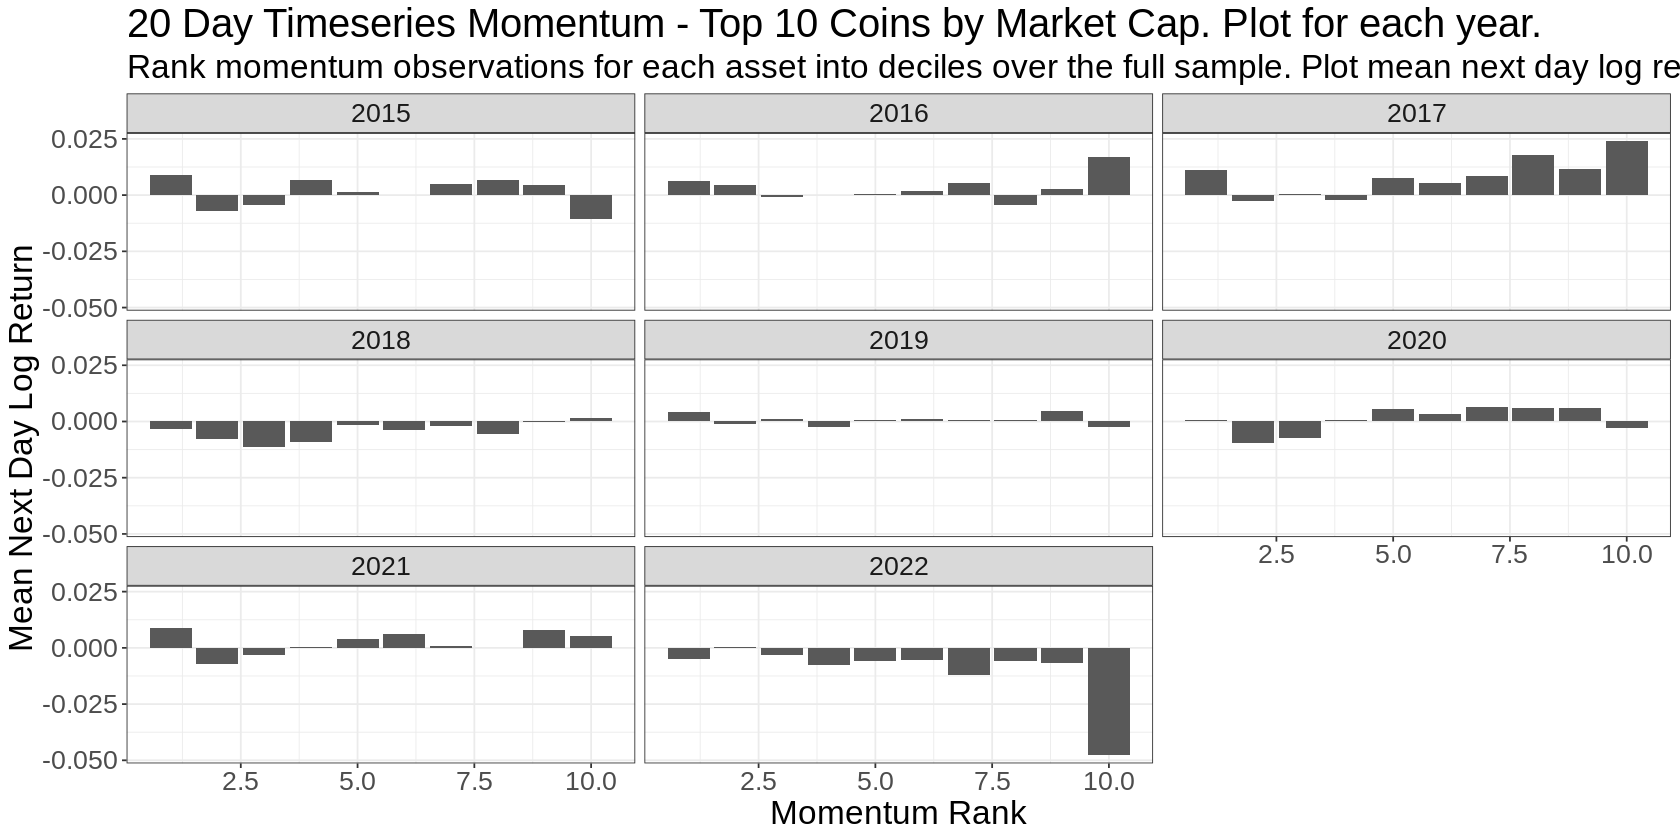

In [8]:
lookback_returns %>%
  filter(is_index == TRUE ) %>%
  mutate(year = year(date)) %>%
  filter(lookback == 20) %>%
  group_by(year, momo_decile) %>%
  summarise(fwd_log_return = mean(fwd_log_return)) %>%
  na.omit() %>%
  ggplot(aes(x=momo_decile,y=fwd_log_return)) +
  geom_bar(stat='identity') +
  labs(
    title = "20 Day Timeseries Momentum - Top 10 Coins by Market Cap. Plot for each year.",
    subtitle = "Rank momentum observations for each asset into deciles over the full sample. Plot mean next day log returns",
    x = 'Momentum Rank',
    y = 'Mean Next Day Log Return'
  ) + facet_wrap(~year)

Same universe.

Calculate momentum factor.

For each asset, rank all the momentum observations into deciles *over the full population*.

Group by decile, plot mean next day log return.

Each sub-plot is a different momentum lookback.

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


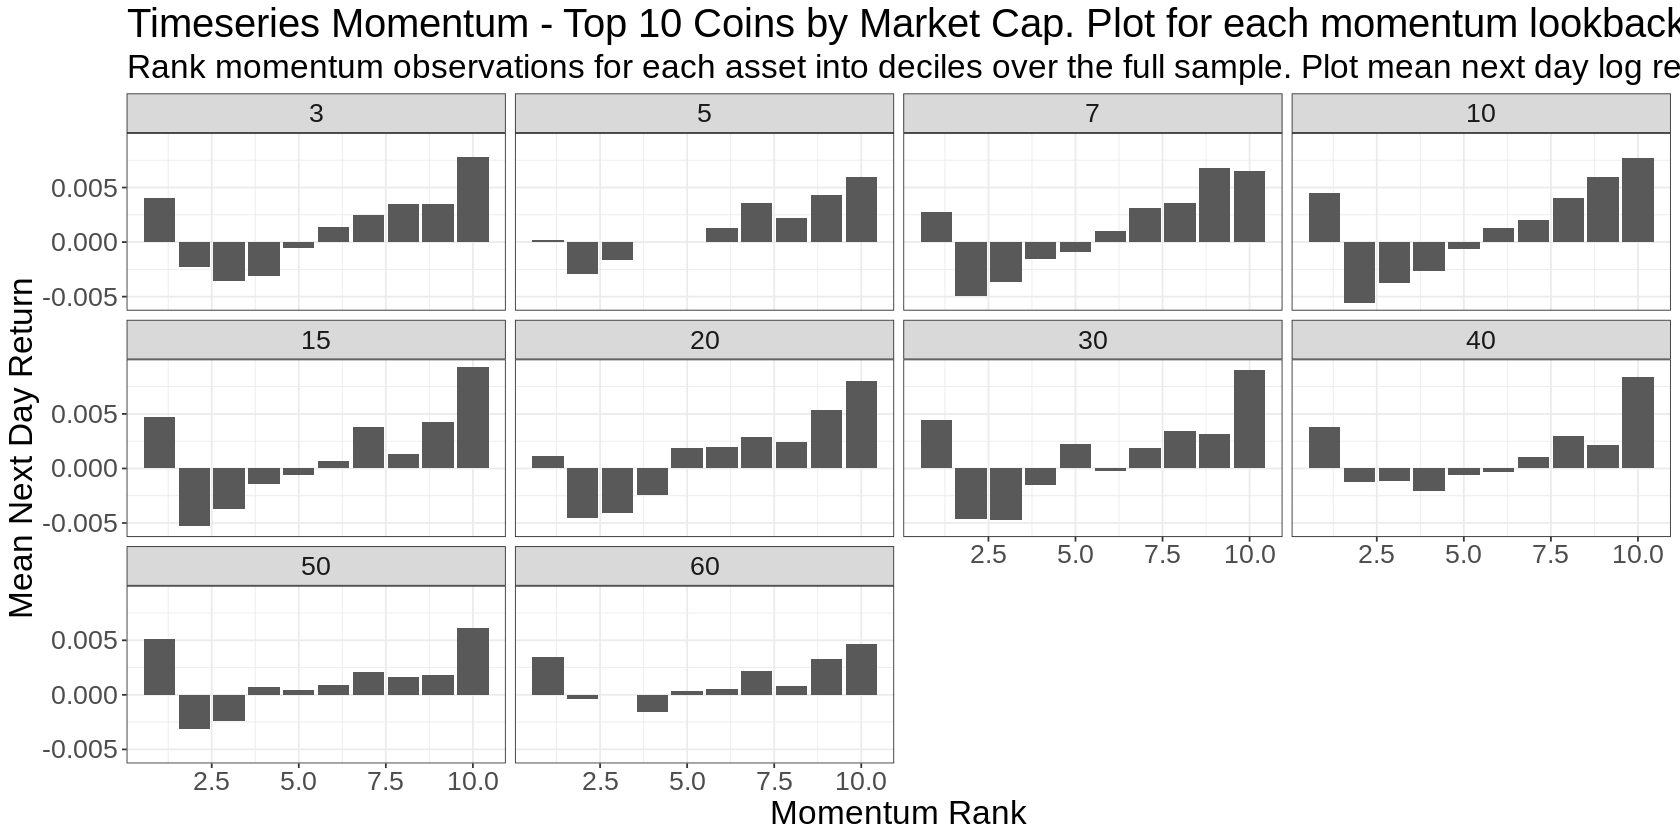

In [9]:
lookback_returns %>%
  filter(is_index == TRUE ) %>%
  group_by(lookback, momo_decile) %>%
  mutate(lookback = factor(lookback)) %>%
  summarise(fwd_log_return = mean(fwd_log_return)) %>%
  na.omit() %>%
  ggplot(aes(x=momo_decile,y=fwd_log_return)) +
  geom_bar(stat='identity') +
  labs(
    title = "Timeseries Momentum - Top 10 Coins by Market Cap. Plot for each momentum lookback.",
    subtitle = "Rank momentum observations for each asset into deciles over the full sample. Plot mean next day log returns",
    x = 'Momentum Rank',
    y = 'Mean Next Day Return'
  ) + facet_wrap(~lookback)

Reversal effect suggests in decile 1 in part may be due to bias in the universe.
I'm running a dynamic universe of "the top 10 coins by market cap the day before on CoinMetrics" but i'm not sure what their selection criteria for including a coin is...

# Summary

Most of this effect is probably just trend-following on the asset class. Not sure to what extent this is adding value other than that - which is the next thing to look at.